In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import os
# import sys
# sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

In [2]:
df = pd.read_csv('data/ZZP.csv', sep=";")
df['Datum'] = pd.to_datetime(df['Datum'], format='%d-%m-%Y')

In [20]:
df.head()

,Datum,ZZP4,ZZP5,ZZP6,ZZP7,ZZP8,ZZP9,ZZP10,ZZP_VVT
0,2023-02-01,0,154,117,83,29,4,0,233
1,2023-02-02,0,154,118,84,29,4,0,235
2,2023-02-03,0,155,118,84,29,4,0,235
3,2023-02-04,0,155,118,84,29,4,0,235
4,2023-02-05,0,155,118,84,29,4,0,235


In [3]:
df['Datum'].unique()

<DatetimeArray>
['2023-02-01 00:00:00', '2023-02-02 00:00:00', '2023-02-03 00:00:00',
 '2023-02-04 00:00:00', '2023-02-05 00:00:00', '2023-02-06 00:00:00',
 '2023-02-07 00:00:00', '2023-02-08 00:00:00', '2023-02-09 00:00:00',
 '2023-02-10 00:00:00',
 ...
 '2024-01-22 00:00:00', '2024-01-23 00:00:00', '2024-01-24 00:00:00',
 '2024-01-25 00:00:00', '2024-01-26 00:00:00', '2024-01-27 00:00:00',
 '2024-01-28 00:00:00', '2024-01-29 00:00:00', '2024-01-30 00:00:00',
 '2024-01-31 00:00:00']
Length: 365, dtype: datetime64[ns]

In [4]:
df.index = pd.DatetimeIndex(df['Datum'], freq='D')

In [5]:
df.head()

,Datum,ZZP4,ZZP5,ZZP6,ZZP7,ZZP8,ZZP9,ZZP10
Datum,,,,,,,,
2023-02-01,2023-02-01,0,154,117,83,29,4,0
2023-02-02,2023-02-02,0,154,118,84,29,4,0
2023-02-03,2023-02-03,0,155,118,84,29,4,0
2023-02-04,2023-02-04,0,155,118,84,29,4,0
2023-02-05,2023-02-05,0,155,118,84,29,4,0


In [6]:
data = df['ZZP5']

In [7]:
data

Datum
2023-02-01    154
2023-02-02    154
2023-02-03    155
2023-02-04    155
2023-02-05    155
             ... 
2024-01-27    139
2024-01-28    140
2024-01-29    141
2024-01-30    139
2024-01-31    139
Freq: D, Name: ZZP5, Length: 365, dtype: int64

ADF Statistic: -2.460126
p-value: 0.125480


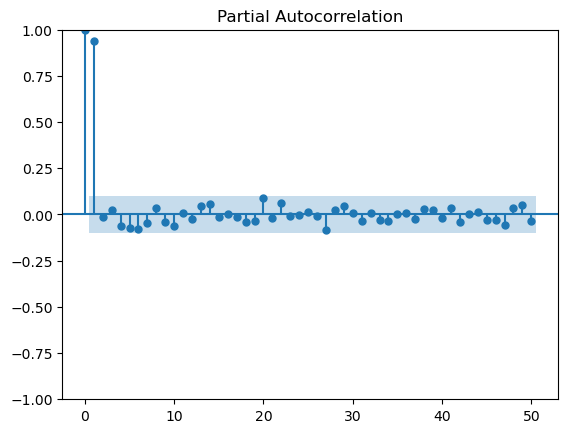

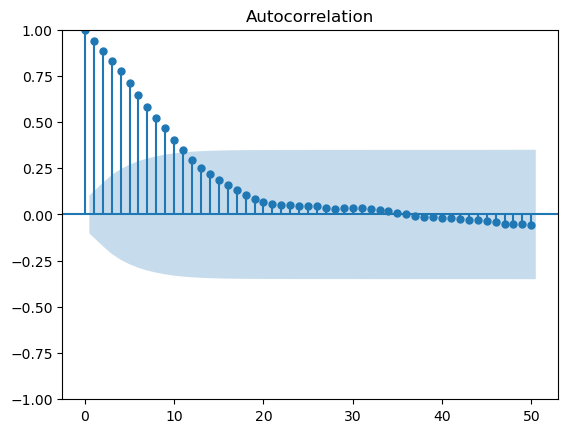

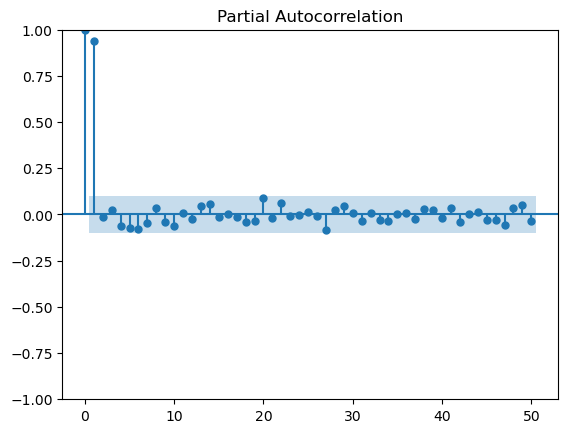

In [8]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check if the series is stationary
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot ACF and PACF
plot_acf(data, lags=50)
plot_pacf(data, lags=50)

In [9]:
# Fit an ARIMA model to your data
# model = ARIMA(data, order=(5,2,5), freq='D')
model = ARIMA(data, order=(1,2,5), freq='D')
model_fit = model.fit()

In [10]:
# Forecast future data points
n_forecast = 100
forecast = model_fit.forecast(steps=n_forecast)

In [11]:
extended_data = pd.concat([data, pd.Series(forecast)], ignore_index=True)

<Axes: >

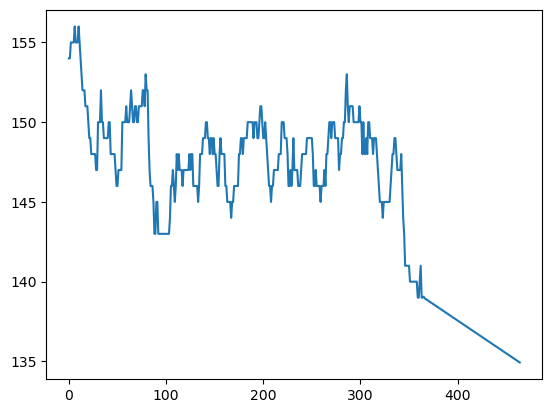

In [12]:
extended_data.plot()

In [13]:
import plotly.graph_objects as go

# Create a plot
fig = go.Figure()

# Add a line trace for the extended_data
fig.add_trace(go.Scatter(x=extended_data.index, y=extended_data, mode='lines', name='extended_data'))

# Set the title and labels
fig.update_layout(title='Extended Data Timeseries', xaxis_title='Time', yaxis_title='Value')

# Show the plot
fig.show()

In [14]:
# Stappenplan:
# - Trendlijn bepalen
# - delta trendlijn bepalen
# - Normaaldistributie maken van delta trendlijn
# - Meerjaren trendlijn maken
# - Op basis van normaal distributie en meerjaren trendlijn voorspelling maken

In [15]:
df = pd.read_csv('data/ZZP.csv', sep=";")
df['Datum'] = pd.to_datetime(df['Datum'], format='%d-%m-%Y')
df['ZZP_VVT'] = df['ZZP6'] + df['ZZP7'] + df['ZZP8'] + df['ZZP9'] + df['ZZP10']

data = df['ZZP_VVT']

time = np.arange(len(data))
slope, intercept = np.polyfit(time, data, 1)

extension_period = 365*3
extended_time = np.arange(len(data) + extension_period)
# Create a trend line
trend = intercept + slope * extended_time
df_extended = pd.DataFrame({'Datum': df['Datum'].iloc[0] + pd.to_timedelta(extended_time, unit='D'), 'trend': trend})

df_extended = pd.concat([df['ZZP_VVT'], df_extended], axis=1)
df_extended['delta'] = df_extended['ZZP_VVT'] - df_extended['trend']

df_extended['synthetic_delta'] = np.random.normal(loc=0.0, scale=df_extended['delta'].std(), size=len(df_extended))
df_extended['synthetic_ZZP_VVT_'] = df_extended['trend'] + df_extended['synthetic_delta']

df_extended['synthetic_ZZP_VVT'] = df_extended['synthetic_ZZP_VVT_'].rolling(window=7).mean()
df_extended = df_extended.dropna(subset=['synthetic_ZZP_VVT'])
df_extended['synthetic_ZZP_VVT'] = df_extended['synthetic_ZZP_VVT'].astype(int)

In [16]:
ts_clients = df_extended['synthetic_ZZP_VVT'].to_dict()
dict_timeseries = {}
dict_timeseries['ts_clients'] = ts_clients

In [ ]:
# Write the updated dictionary back to a JSON file
with open('data/dict_timeseries.json', 'w') as f:
    json.dump(dict_timeseries, f)

In [ ]:
# Load the dictionary from a JSON file
with open('data/dict_timeseries.json', 'r') as f:
    dict_test = json.load(f)

In [22]:
df_extended.to_csv('data/ZZP_extended.csv', sep=';', index=False)

In [4]:
df['ZZP_VVT'] = df['ZZP6'] + df['ZZP7'] + df['ZZP8'] + df['ZZP9'] + df['ZZP10']



In [25]:
data = df['ZZP_VVT']
# Assuming 'data' is your time series
time = np.arange(len(data))
slope, intercept = np.polyfit(time, data, 1)

extension_period = 365*3
extended_time = np.arange(len(data) + extension_period)
# Create a trend line
trend = intercept + slope * extended_time

In [42]:
ts_clients = data.to_dict()

In [47]:

# Import the dictionary from ts.py
from data.ts import dict_timeseries

# Update the dictionary
dict_timeseries['ts_clients'].update(ts_clients)

# Write the updated dictionary back to ts.py
with open('data/ts.py', 'a') as f:
    f.write(f'\dict_timeseries = {dict_timeseries}\n')

In [53]:
import json

# Import the dictionary from ts.py
from data.ts import dict_timeseries

# Update the dictionary
dict_timeseries['ts_clients'].update(ts_clients)

# Write the updated dictionary back to a JSON file
with open('data/dict_timeseries.json', 'w') as f:
    json.dump(dict_timeseries, f)

In [54]:
# Load the dictionary from a JSON file
with open('data/dict_timeseries.json', 'r') as f:
    dict_timeseries = json.load(f)


In [59]:
dict_timeseries['ts_purchases']

{}

In [27]:
extended_time

array([   0,    1,    2, ..., 1457, 1458, 1459])

In [28]:
df_extended = pd.DataFrame({'Datum': df['Datum'].iloc[0] + pd.to_timedelta(extended_time, unit='D'), 'trend': trend})

In [29]:
df_extended.head()

,Datum,trend
0,2023-02-01,238.130519
1,2023-02-02,238.168022
2,2023-02-03,238.205526
3,2023-02-04,238.243029
4,2023-02-05,238.280533


In [30]:
df_extended = pd.concat([df['ZZP_VVT'], df_extended], axis=1)

In [31]:
df_extended.shape

(1460, 3)

In [32]:
df_extended['delta'] = df_extended['ZZP_VVT'] - df_extended['trend']

In [38]:
df_extended = pd.concat([df['ZZP_VVT'], df_extended], axis=1)
df_extended['delta'] = df_extended['ZZP_VVT'] - df_extended['trend']

df_extended['synthetic_delta'] = np.random.normal(loc=0.0, scale=df_extended['delta'].std(), size=len(df_extended))
df_extended['synthetic_ZZP_VVT_'] = df_extended['trend'] + df_extended['synthetic_delta']

df_extended['synthetic_ZZP_VVT'] = df_extended['synthetic_ZZP_VVT_'].rolling(window=7).mean()
df_extended = df_extended.dropna(subset=['synthetic_ZZP_VVT'])
df_extended['synthetic_ZZP_VVT'] = df_extended['synthetic_ZZP_VVT'].astype(int)

array([         nan, 239.03129046, 238.71232171, ..., 290.82296808,
       292.56003245, 293.58030402])

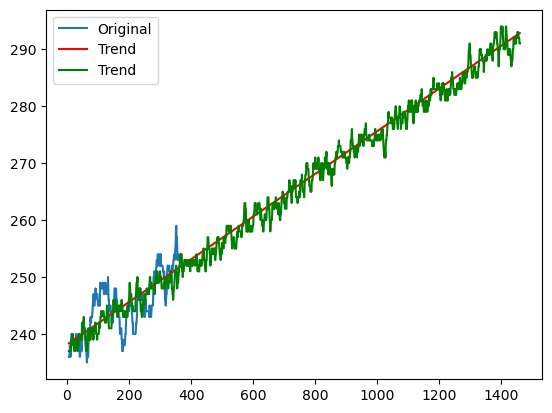

In [39]:
plt.plot(df_extended['ZZP_VVT'], label='Original')
plt.plot(df_extended['trend'], label='Trend', color='red')
plt.plot(df_extended['synthetic_ZZP_VVT'], label='Trend', color='green')
plt.legend()
plt.show()

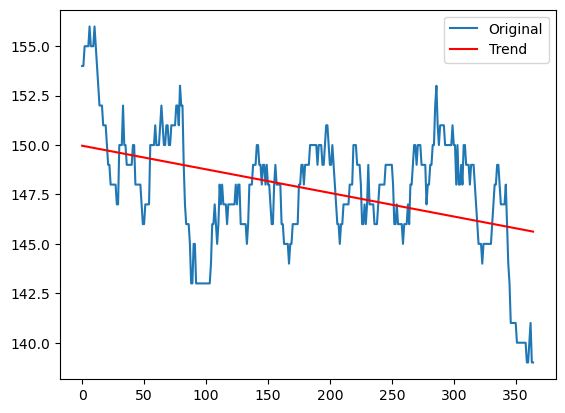

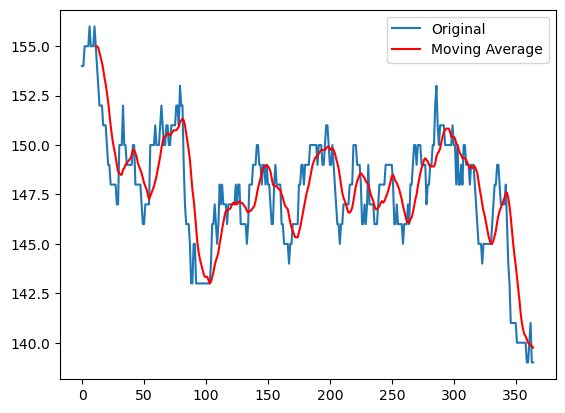

In [24]:


# Assuming 'data' is your time series
time = np.arange(len(data))
slope, intercept = np.polyfit(time, data, 1)

# Create a trend line
trend = intercept + slope * time

# Plot the original time series and the trend
plt.plot(data, label='Original')
plt.plot(time, trend, label='Trend', color='red')
plt.legend()
plt.show()

# Moving average
data_ma = data.rolling(window=12).mean()  # window size depends on the nature of the data

# Plot the original time series and the moving average
plt.plot(data, label='Original')
plt.plot(data_ma, label='Moving Average', color='red')
plt.legend()
plt.show()

In [25]:
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18